# Geospatial Transforms Introduction

Instructors: [Tyler Sutterley](mailto:tsutterl@uw.edu), [Hannah Besso](mailto:bessoh2@uw.edu) and [Scott Henderson](mailto:scottyh@uw.edu), some material adapted from [David Shean](mailto:dshean@uw.edu)


Learning Objectives
-------------------
- Review fundamental concepts of coordinate reference systems
- Learn how to access coordinate reference metadata
- Learn basic coordinate transformations

Introduction
-------------
ICESat-2 elevations are spatial point data. Spatial data contains information about where on the surface of the Earth a certain feature is located, and there are many different ways to define this location. Two main characteristics of the Earth make defining locations difficult: 1) it's shape approximates an ellipsoid (working with spatial data would be a lot easier if the world were flat!) 2) It's not actually perfectly ellipsoidal. Paper maps and computer screens are flat, which causes issues when we try to use them to display rounded shapes (like the Earth's surface). Making things even more difficult, the irregular shape of the Earth means there is no one perfect model of it's surface on which we could place our spatial data points. Instead, we're left with many models of the Earth's surface that are optimized for different locations and purposes. 

In [26]:
import geopandas as gpd
import matplotlib.patches
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import netCDF4
import numpy as np
import osgeo.gdal, osgeo.osr
import pyproj
import rasterio
import rasterio.features
import rasterio.warp
import re
import warnings
# turn off warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

In this notebook, we will explore coordinate systems, map projections, geophysical concepts and available geospatial software tools.

We're going to use [geopandas](https://geopandas.org) and [matplotlib](https://matplotlib.org/) for visualization.

[geopandas](https://geopandas.org) is built on top of other great computing and geospatial tools, which will make our lives easier on this notebook.
- [numpy: Scientific Computing Tools For Python](http://www.numpy.org)
- [pandas: Python Data Analysis Library](https://pandas.pydata.org)
- [shapely: PostGIS-ish operations outside a database context for Python](https://shapely.readthedocs.io)
- [GEOS: geometry, spatial operations](https://trac.osgeo.org/geos)
- [GDAL/OGR: Pythonic interface to the Geospatial Data Abstraction Library (GDAL)](https://gdal.org)
- [fiona: Python wrapper for vector data access functions from the OGR library](https://fiona.readthedocs.io)
- [PROJ: cartographic projection and coordinate transformation library](https://proj.org)
- [pyproj: Python interface to PROJ library](https://pyproj4.github.io)

Let's Start by Making a Map
---------------------------

### **Q: Why would we use maps to display geographic data?**

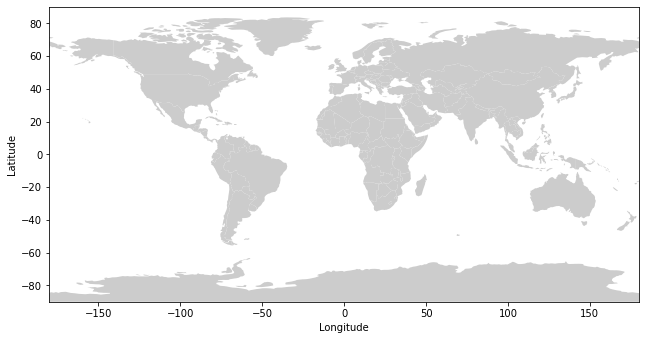

In [27]:
fig,ax1 = plt.subplots(num=1, figsize=(10,4.55))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='0.8', edgecolor='none')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

### **Q: So how did we just display a rounded shape on a flat surface?**

#### From [Earth Data Science](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/):

The Components of a Coordinate Reference System (CRS):
-------------------------
* **Projection Information:** the mathematical equation used to flatten objects that are on a round surface (e.g. the earth) so you can view them on a flat surface (e.g. your computer screens or a paper map).* **Projection Information:** the mathematical equation used to flatten objects that are on a round surface (e.g. the earth) so you can view them on a flat surface (e.g. your computer screens or a paper map).
* **Coordinate System:** the X, Y, and Z grid upon which your data is overlayed and how you define where a point is located in space.
* **Horizontal and vertical units:** The units used to define the grid along the x, y (and z) axis.
* **Datum:** A modeled version of the shape of the earth which defines the origin used to place the coordinate system in space. 

Geographic Coordinate Systems
-----------------------------
Locations on Earth are usually specified in a geographic coordinate system consisting of
- _Longitude_ specifies the angle east and west from the Prime Meridian (102 meters east of the Royal Observatory at Greenwich)
- _Latitude_ specifies the angle north and south from the Equator

The map above _projects_ geographic data from the Earth's 3-dimensional geometry on to a flat surface.  [The three common types of projections are _cylindric_, _conic_ and _planar_](https://courses.washington.edu/gis250/lessons/projection/).  Each type is a different way of flattening the Earth's geometry into 2-dimensional space.

This map is in an _Equirectangular Projection_ (Plate Carrée), where latitude and longitude are equally spaced.  Equirectangular is cylindrical projection, which has benefits as latitudes and longitudes form straight lines.  However, this projection distorts both _shape_ and _distance_, particularly at higher latitudes.

To illustrate this, check out the normalized grid area at different latitudes on the map below:

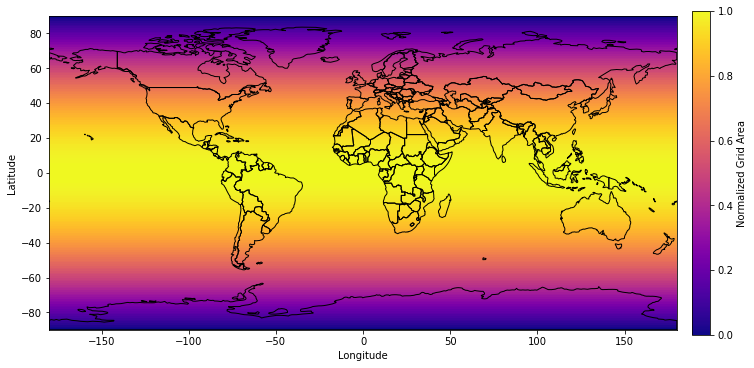

In [28]:
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (1.0,1.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
# calculate and plot grid area
gridlon,gridlat = np.meshgrid(longitude, latitude)
im = ax1.imshow(np.cos(gridlat*np.pi/180.0),
    extent=(minlon,maxlon,minlat,maxlat), 
    interpolation='nearest',
    cmap=plt.cm.get_cmap('plasma'),
    origin='lower')
# add coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Normalized Grid Area')
cbar.solids.set_rasterized(True)
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

Notes on Projections
--------------------

_There is no perfect projection for all purposes_

Not all maps are good for ocean or land navigation

Not all projections are good for polar mapping

Every projection will distort either shape, area, distance or direction

- _conformal_ projections minimize distortion in shape
- _equal-area_ projections minimize distortion in area
- _equidistant_ projections minimize distortion in distance
- _true-direction_ projections minimize distortion in direction

While there are [projections that are better suited for specific purposes](https://pubs.usgs.gov/gip/70047422/report.pdf), [choosing a map projection](https://pubs.usgs.gov/pp/1395/report.pdf) is a bit of an art 🦋

[![](https://imgs.xkcd.com/comics/map_projections.png)](https://xkcd.com/977/)

### **Q: What is your favorite projection?** 🌎
### **Q: What projections do you use in your research?** 🌏

#### Using [geopandas](https://geopandas.org), we can get CRS information about our data, in this case a vector file with polygons of the world's countries:

In [29]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**EPSG:** European Petroleum Survey Group. Back in the day, this group created codes to standardize how different reference systems were refered to, and now EPSG codes are widely used in geospatial work.

_If CRS metadata on any products isn't included within the data product, make sure it's in the right projection and datum. Often metadata reports or readme files will provide this information._

#### And we can also reproject it fairly easily, as long as our vertical reference (our ellipsoid or geoid) stays the same:
* Remember: "The projection is the mathematical equation used to flatten objects that are on a round surface (e.g. the earth) so you can view them on a flat surface (e.g. your computer screens or a paper map)."

In [30]:
world_arctic = world.to_crs('epsg:3031')

#### Did it work?

In [31]:
world_arctic.crs

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 🎉 🎉 🎉

Text(0.5, 1.0, 'EPSG:3031')

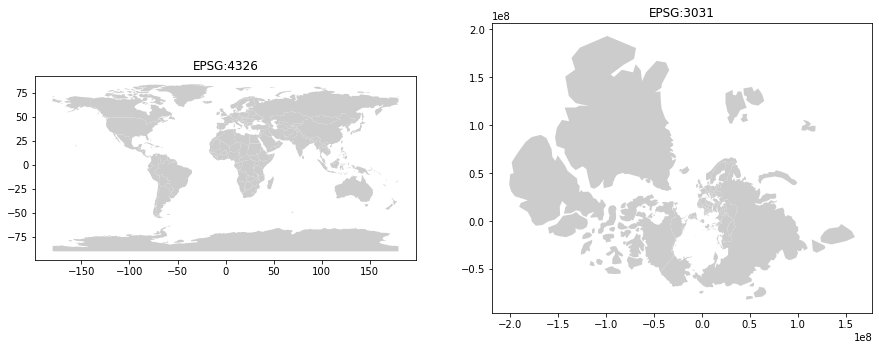

In [32]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
world.plot(ax = ax[0], color='0.8', edgecolor='none')
world_arctic.plot(ax = ax[1], color='0.8', edgecolor='none')

ax[0].set_title('EPSG:4326')
ax[1].set_title('EPSG:3031')

#### If we zoom in on Anatarctica, we can see how big a difference these projections make:

In [33]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Text(0.5, 1.0, 'EPSG:3031')

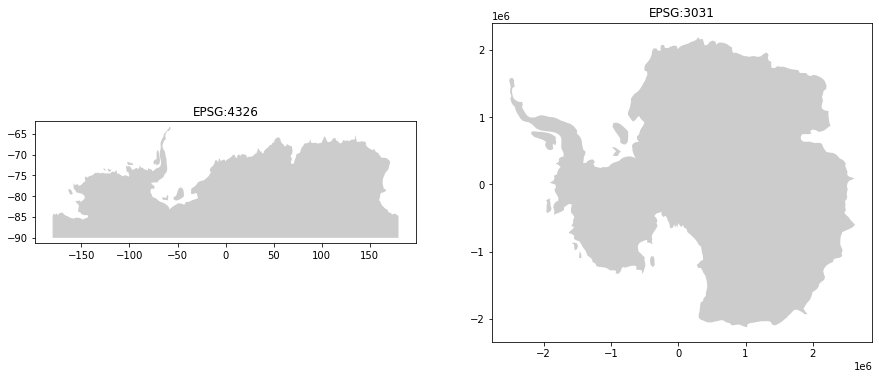

In [34]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
world[world['name']=='Antarctica'].plot(ax = ax[0], color='0.8', edgecolor='none')
world_arctic[world_arctic['name']=='Antarctica'].plot(ax = ax[1], color='0.8', edgecolor='none')

ax[0].set_title('EPSG:4326')
ax[1].set_title('EPSG:3031')

Ahhh Antarctica 🐧

Stereographic projections are common for mapping in polar regions.  A lot of legacy data products for both Greenland and Antarctica use polar stereographic projections. Some other polar products, such as NSIDC EASE/EASE-2 grids, are in _equal-area_ projections.  

Stereographic projections are _conformal_, preserving angles but not distances or areas.  _Equal-area_ map projection cannot be conformal, nor can a conformal map projection be equal-area.  

#### Let's look at how this stereographic projection distorts area around the origin:

In [35]:
def scale_areas(lat, flat=1.0/298.257223563, ref=70.0):
    """
    Area scaling factors for a polar stereographic projection including special
        exact pole case

    Inputs:
        lat: latitude (degrees north)

    Options:
        flat: ellipsoidal flattening
        ref: reference latitude (standard parallel)

    Returns:
        scale: area scaling factors at input latitudes

    References:
        Snyder, J P (1982) Map Projections used by the U.S. Geological Survey
            Forward formulas for the ellipsoid.  Geological Survey Bulletin
            1532, U.S. Government Printing Office.
        JPL Technical Memorandum 3349-85-101
    """
    # convert latitude from degrees to positive radians
    theta = np.abs(lat)*np.pi/180.0
    # convert reference latitude from degrees to positive radians
    theta_ref = np.abs(ref)*np.pi/180.0
    # square of the eccentricity of the ellipsoid
    # ecc2 = (1-b**2/a**2) = 2.0*flat - flat^2
    ecc2 = 2.0*flat - flat**2
    # eccentricity of the ellipsoid
    ecc = np.sqrt(ecc2)
    # calculate ratio at input latitudes
    m = np.cos(theta)/np.sqrt(1.0 - ecc2*np.sin(theta)**2)
    t = np.tan(np.pi/4.0 - theta/2.0)/((1.0 - ecc*np.sin(theta)) / \
        (1.0 + ecc*np.sin(theta)))**(ecc/2.0)
    # calculate ratio at reference latitude
    mref = np.cos(theta_ref)/np.sqrt(1.0 - ecc2*np.sin(theta_ref)**2)
    tref = np.tan(np.pi/4.0 - theta_ref/2.0)/((1.0 - ecc*np.sin(theta_ref)) / \
        (1.0 + ecc*np.sin(theta_ref)))**(ecc/2.0)
    # distance scaling for general and polar case
    k = (mref/m)*(t/tref)
    kp = 0.5*mref*np.sqrt(((1.0+ecc)**(1.0+ecc))*((1.0-ecc)**(1.0-ecc)))/tref
    # calculate area scaling factor
    scale = np.where(np.isclose(theta,np.pi/2.0),1.0/(kp**2),1.0/(k**2))
    return scale

**pyproj transform** objects can be used to change the Coordinate Reference System of arrays.

Here, we'll use the transform to get the latitude and longitude coordinates of points in this projection (an _inverse_ tranformation), and get the polar stereographic coordinates for plotting a circle around the standard parallel (-71°) of this projection (a _forward_ transformation).

The _standard parallel_ of a stereographic projection is the latitude where there is no scale distortion.

In [36]:
crs4326 = pyproj.CRS.from_epsg(4326)    # WGS84
crs3031 = pyproj.CRS.from_epsg(3031)    # Antarctic Polar Stereographic
transformer = pyproj.Transformer.from_crs(crs4326, crs3031, always_xy=True)

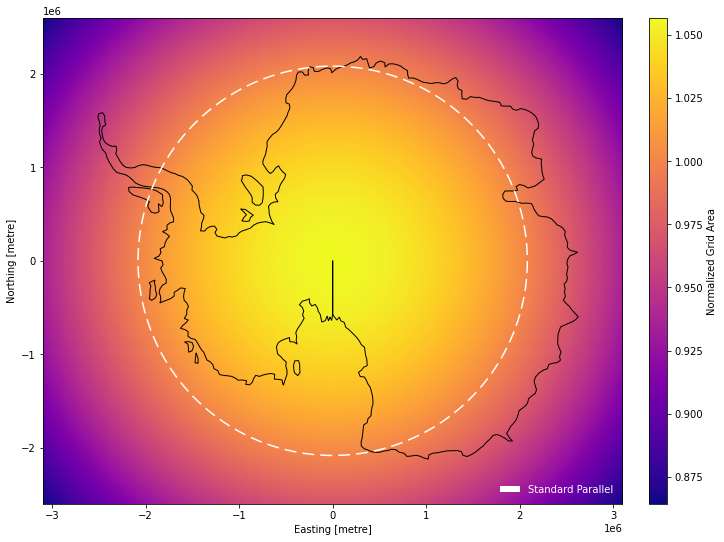

In [37]:
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000)
dx,dy = (10000,10000)
# create a grid of polar stereographic points
X = np.arange(xmin,xmax+dx,dx)
Y = np.arange(ymin,ymax+dy,dy)
gridx,gridy = np.meshgrid(X, Y)
# convert polar stereographic points to latitude/longitude (WGS84)
gridlon,gridlat = transformer.transform(gridx, gridy,
    direction=pyproj.enums.TransformDirection.INVERSE)
# calculate and plot grid area
cf = crs3031.to_cf()
flat = 1.0/cf['inverse_flattening']
gridarea = scale_areas(gridlat, flat=flat, ref=cf['standard_parallel'])
im = ax3.imshow(gridarea,
    extent=(xmin,xmax,ymin,ymax), 
    interpolation='nearest',
    cmap=plt.cm.get_cmap('plasma'),
    origin='lower')
# add circle around standard parallel
ref_lon = np.arange(360)
ref_lat = np.ones((360))*cf['standard_parallel']
# convert latitude/longitude (WGS84) points to polar stereographic
ref_x,ref_y = transformer.transform(ref_lon, ref_lat,
    direction=pyproj.enums.TransformDirection.FORWARD)
l, = ax3.plot(ref_x, ref_y, '--', color='w', dashes=(8,4), label='Standard Parallel')
# add coastlines
world2 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(crs3031)
world2.plot(ax=ax3, color='none', edgecolor='black')
# set x and y limits
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3031.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Normalized Grid Area')
cbar.solids.set_rasterized(True)
# add legend
lgd = ax3.legend(loc=4,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
for i,text in enumerate(lgd.get_texts()):
    text.set_color(l.get_color())
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

Why is there a black line to the pole?  Because this coastline was reprojected from a Equirectangular projection.  That's the bottom of the Equirectangular map.

### **<span style="color:orange"> Load in IS2 data with geopandas and project it to 3031, and plot with the antarctica polygon to show that they align?</span>**

### **Q: Are you more familiar with using vector or raster data?**
### **Q: Do you more often use GIS software or command-line tools?**

There are different tools for working with raster and vector data.  Some are more advantageous for one data type over the other.

Let's find the coordinate reference system of some data products using some common geospatial tools.

Geospatial Data Abstraction Library
-----------------------------------

The [Geospatial Data Abstraction Library (GDAL/OGR)](https://gdal.org/) is a powerful piece of software. 

It can read, write and query a wide variety of raster and vector geospatial data formats, transform the coordinate system of images, and manipulate other forms of geospatial data.

It is the backbone of a _large_ suite of geospatial libraries and programs.

<!-- It can also be an absolute pain in the neck to install, particularly if you are wanting specific drivers not included in the [default installation](https://trac.osgeo.org/gdal/wiki/BuildingOnUnix).-->

There are a number of wrapper libraries (e.g. [rasterio](https://rasterio.readthedocs.io/), [rioxarray](https://corteva.github.io/rioxarray), [shapely](https://shapely.readthedocs.io/), [fiona](https://fiona.readthedocs.io/)) that provide more user-friendly interfaces with GDAL functionality.

Similar to pyproj CRS objects, GDAL `SpatialReference` functions can provide a lot of information about a particular Coordinate Reference System

GDAL command-line utilities also allows for quick inspection of Coordinate Reference Systems (CRS) and geospatial data files

In [36]:
! gdalsrsinfo EPSG:3031


PROJ.4 : +proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs

OGC WKT2:2018 :
PROJCRS["WGS 84 / Antarctic Polar Stereographic",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Antarctic Polar Stereographic",
        METHOD["Polar Stereographic (variant B)",
         

#### <span style="color:orange"> Now let's read in a DEM that overlaps with our IS2 data: 
* Read in with rasterio and display the crs
* Reproject raster
* Plot the reprojected data within the antarctica polygon to show they line up?
* Plot the ATL06 over the DEM to show they line up
### ...</span>

### Let's look back at our CRS descriptions:

In [24]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
world_arctic.crs

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### We can see that the projections are different, but the Datums are the same (the WGS84 ellipsoid).

### **Q: So what is a Datum?**

Reference Systems and Datums
----------------------------
Coordinates are defined to be in _reference_ to the origins of the coordinate system
- Horizontally, coordinates are in reference to the Equator and the Prime Meridian
- Vertically, heights are in reference to a [_datum_](https://vdatum.noaa.gov/docs/datums.html)

Two common vertical datums are the reference _ellipsoid_ and the reference _geoid_.

What are they and what is the difference?
- To ﬁrst approximation, the Earth is a sphere (🐄) with a radius of 6371 kilometers.
- To a better approximation, the Earth is a slightly flattened ellipsoid with the polar axis 22 kilometers shorter than the equatorial axis.
- To an even better approximation, the Earth's shape can be described using a reference geoid, which undulates 10s of meters above and below the reference ellipsoid. The difference in height between the ellipsoid and the geoid are known as _geoid heights_.

The **geoid** is an _equipotential surface_, perpendicular to the force of gravity at all points and with a constant geopotential. Reference ellipsoids and geoids are both created to largely coincide with mean sea level if the oceans were at rest.

An **ellipsoid** can be considered a _simplification of a geoid_.

![Derived from the International Centre for Global Earth Models (ICGEM)](https://drive.google.com/uc?id=1MTCZnfUNvhqSuQnUSbdj-iqPmx4jDQm5)

[PROJ hosts grids for shifting both the horizontal and vertical datum](https://cdn.proj.org/), such as gridded [EGM2008 geoid height values](https://cdn.proj.org/us_nga_egm08_25.tif)

Additional geoid height values can be calculated at the [International Centre for Global Earth Models (ICGEM)](http://icgem.gfz-potsdam.de/home)

Why Does This Matter?
---------------------

ICESat-2 elevations are in reference to the WGS84 (G1150) ellipsoid.  ICESat-2 data products also include geoid heights from the [EGM2008 geoid](https://www.usna.edu/Users/oceano/pguth/md_help/html/egm96.htm).  Different ground-based, airborne or satellite-derived elevations may use a separate datum entirely.  _Elevations have to be in the same reference frame when comparing heights_.

Different datums have different purposes.  Heights above mean sea level are needed for ocean and sea ice heights, and are also commonly used for terrestrial mapping (e.g. as elevations of mountains).  Ellipsoidal heights are commonly used for estimating land ice height change.

...

#### <span style="color:orange"> Let's transform the IS2 and raster data to show how vertical transformations work </span>
* gdalwarp for raster
* transformer for vector